In [1]:
# REF
# https://github.com/jackyko1991/Image-Transform/blob/master/main.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import scipy

In [3]:
moving_image, header = nrrd.read("20231013_191710_ref_2678_2805.nrrd")
ref_image, header = nrrd.read("20231013_191710_ref_19414_19584.nrrd")

moving_image = moving_image[:,:,::5]
ref_image = ref_image[:,:,::5]

In [4]:
affine_matrix = np.array([[1, 0, 0, 300], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

In [5]:
import cupy as cp
import cupyx.scipy.ndimage as ndimage

In [6]:
moving_image_gpu = cp.array(cp.clip(moving_image, 0, np.max(moving_image)), dtype=cp.uint16)
ref_image_gpu = cp.array(cp.clip(ref_image, 0, np.max(ref_image)), dtype=cp.uint16)
affine_matrix_gpu = cp.array(affine_matrix, dtype=cp.int16)

In [32]:
moving_image_out_gpu = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape), offset = [0,0,10])

In [33]:
moving_image_out = cp.asnumpy(moving_image_out_gpu)

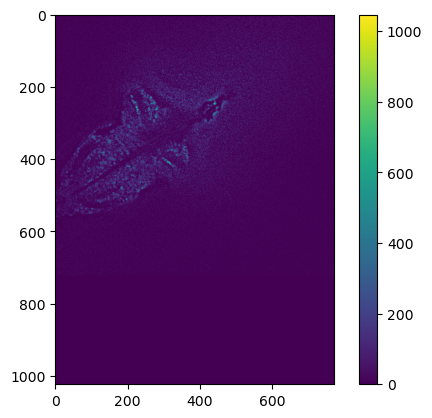

In [34]:
plt.imshow(moving_image_out[:,:,15])
plt.colorbar()

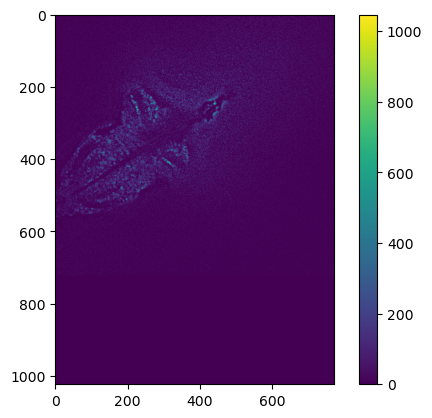

In [31]:
plt.imshow(moving_image_out[:,:,15])
plt.colorbar()

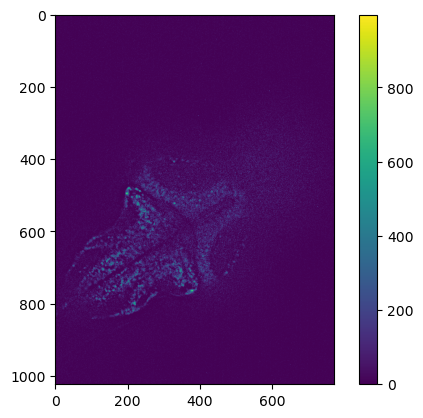

In [23]:
plt.imshow(cp.asnumpy(moving_image_gpu[:,:,20]))
plt.colorbar()

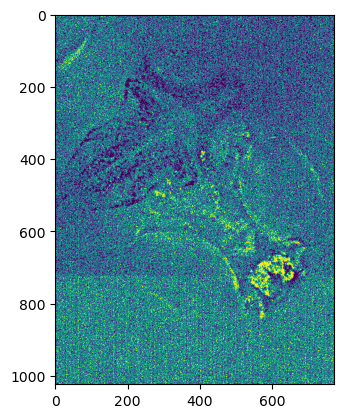

In [64]:
# https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_GradientDescent.ipynb
# mse derivative

# dMSE the derivative of mse with repect to the transform parameters mu
# dM   =  d M(y)/ dy    # gradient of the transformed moving image
# dT   =  d T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
# dMdT = d M(y)/ dy * d T(x,mu) / dmu

# compute the gradient of the transformed image

# the first term in eq.4, a scalar

n =  np.product(ref_image_gpu.shape, dtype= cp.uint16)
dmse = cp.multiply(cp.float32(2/n) , (moving_image_out_gpu-ref_image_gpu))

plt.imshow(cp.asnumpy(dmse[:,:, 20]))

dmse = dmse.flatten()

In [59]:
sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant', output = cp.int16)
sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant', output = cp.int16)
sz = ndimage.sobel(moving_image_out_gpu,axis=2,mode='constant', output = cp.int16)

sx = sx.flatten()
sy = sy.flatten()
sz = sy.flatten()

In [60]:
W, H, D = moving_image_out_gpu.shape

In [61]:
x = cp.arange(W, dtype = cp.uint16)
y = cp.arange(H, dtype = cp.uint16)
z = cp.arange(D, dtype = cp.uint16)
x_t, y_t, z_t  = cp.meshgrid(x,y,z)
x_t = x_t.flatten()
y_t = y_t.flatten()
z_t = z_t.flatten()

In [62]:
dMu  = cp.array([
        cp.sum(x_t*sx*dmse, dtype=cp.float16), cp.sum(y_t*sx*dmse, dtype=cp.float16), cp.sum(z_t*sx*dmse, dtype=cp.float16), cp.sum(sx*dmse, dtype=cp.float16),
        cp.sum(x_t*sy*dmse, dtype=cp.float16), cp.sum(y_t*sy*dmse, dtype=cp.float16), cp.sum(z_t*sy*dmse, dtype=cp.float16), cp.sum(sy*dmse, dtype=cp.float16),
        cp.sum(x_t*sz*dmse, dtype=cp.float16), cp.sum(y_t*sz*dmse, dtype=cp.float16), cp.sum(z_t*sz*dmse, dtype=cp.float16), cp.sum(sz*dmse, dtype=cp.float16),
         ])

In [63]:
dMu

array([      -inf,       -inf, -5.508e+03, -4.592e+02, -8.776e+03,
       -3.674e+04,  4.622e+02, -6.648e+00, -8.776e+03, -3.674e+04,
        4.622e+02, -6.648e+00], dtype=float16)

In [142]:
numIterations = 10
stepSize = 15
nMu = cp.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
affine_matrix = cp.vstack([nMu.reshape(3,4), [0,0,0,1]])
for i in range(numIterations):
    v = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape))

    dmse = (2/n)* (v-u)
    dmse = dmse.flatten()

    
    MSE = cp.square(v-u).mean()
    sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant')
    sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant')
    sz = ndimage.sobel(moving_image_out_gpu,axis=2,mode='constant')
    
    sx = sx.flatten()
    sy = sy.flatten()
    sz = sy.flatten()

    dMu  = cp.array([
            cp.sum(x_t*sx*dmse), cp.sum(y_t*sx*dmse), cp.sum(z_t*sx*dmse), cp.sum(sx*dmse),
            cp.sum(x_t*sy*dmse), cp.sum(y_t*sy*dmse), cp.sum(z_t*sy*dmse), cp.sum(sy*dmse),
            cp.sum(x_t*sz*dmse), cp.sum(y_t*sz*dmse), cp.sum(z_t*sz*dmse), cp.sum(sz*dmse),
             ])

    nMu = np.array(nMu) - ( stepSize * np.array(dMu ))

In [18]:
# # image registration using gradient descent
# def gdOptimiser(u,v,numIterations,stepSize):
#     # initial parameters 
#     nMu = [0,0]
#     dT = np.array([[1,0],[0,1]])
#     # start the optimisation
#     for i in range(numIterations):
#         # transform the moving image using nMu
#         v_t = imTransform(v,nMu)
#         tMshow = 0
#         if tMshow:
#             f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
#             f.add_subplot(1,2, 1)
#             plt.imshow(v_t)
#         #compute the metric value
#         mv = mseMetric(u,v_t)
#         # compute the metric derivative
#         dMu = mbdMSE(u,v_t,dT)        
#         # update the parameters 
#         nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
#         print(i,": ",mv," , ", nMu)
#     return nMu

# print("numIterations : ", numIterations)
# print("stepSize      : ", stepSize)   

# # numIterations = 119
# # stepSize      = 15